# Apply machine learning to audio analysis

First we want to upload our labeled and unlabeled dataset for future use to train our model

In [1]:
### Dependencies were already installed previously on ubuntu
### Comet: experiment tracking and visual tools

from comet_ml import Experiment

import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa # audio analysis
import librosa.display # this submodule needs to be imported explicitly
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import os

In [2]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
# Sequential: creates a sequential model, ideal to create plain stack of layers
# each layer has exactly one input tensor and one output tensor

# Layers: basic building blacks of neural networks in Keras, consists of a
# tensor-in and tensor-out computation function and some state

# Dense, Dropout and Activartion are classes from layers:
# Activation and dense: Core layers. Activation applies an activation function
# to an output. The output has the same shape as the input.
# Dropout: regularization layer.

# Adam: it's an algorithm, an optimization, stochastic gradient descent method
#based on adaptive estimation of first and second order moments.

# to_categorical: converts a class vectors (integers) to a binary class matrix


In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
# Keras now is fully integrated to Tensorflow, so to_categorical and Adam
# can't be imported directly from keras, therefore, the update:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

2021-12-01 17:00:00.078022: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-01 17:00:00.078079: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
# Create a Comet Experiment, to capture any and all artifacts
# such as audio files, visualization, model, dataset, system information and training metrics
experiment = Experiment(api_key = "Xa6eGiuYFngDcAJ9PVY1WpZp0", project_name = "SetA")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/negromontebs/seta/9d145cda85d7488c9408153fdf369848



In [6]:
# Load dataset
df = pd.read_csv('set_a.csv')


# Create a list of the labels. Currently there are 5 labels: 'artifact', 'extrahls', 'murmur', 'normal', nan
labels = list(df['label'].unique())

In [7]:
# grabs a single audio file from each class
files = dict()
datasetSize = 1

#Iteration over the labels and 

for i in range(len(labels)):
    
    #if the dataset contains itens with  the iterated label
    labelBoolean = (df['label'] == labels[i])
    #pick those items and make a new dataFrame with a spefic size
    dfItem = df[labelBoolean][:datasetSize]
    #reset the index to for easier selection
    tmp = dfItem.reset_index()
    #string with the directory
    path = '{}'.format(tmp['fname'][0])
    #print (path) #[0] was taken off, error in range
    #save the string to the dictionary
    files[labels[i]] = path


KeyError: 0

set_a/artifact__201012172012.wav
set_a/extrahls__201101070953.wav
set_a/murmur__201101051104.wav
set_a/normal__201101070538.wav


KeyError: nan

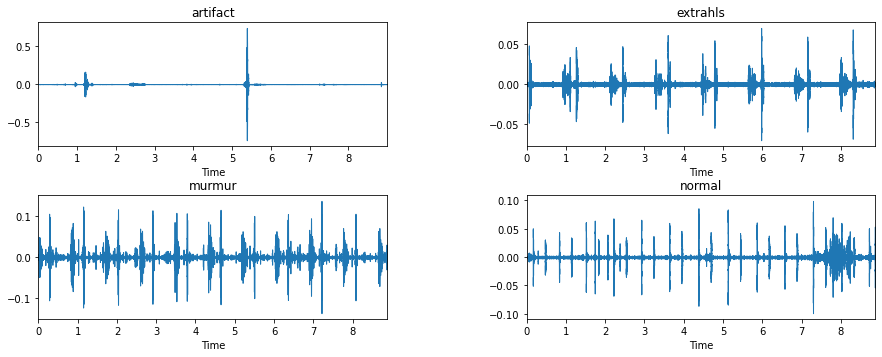

In [8]:
# To plot the waveforms, using librosa's display.waveplot function:

fig = plt.figure(figsize=(15,15))
#experiment.log_image('label_examples.png')
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)


for i, lab in enumerate(labels):
    # i = index
    # lab = name of the label at current index
    fn = files[lab]
    print(fn)
    fig.add_subplot(5,2,1+i)
    plt.title(lab)
    data, sample_rate = librosa.load(fn)
    librosa.display.waveplot(data, sr = sample_rate)
    
plt.savefig('label_examples.png')

# Log graphic of waveforms to comet:
experiment.log_image('label_examples.png')

In [9]:
# Log audio files to Comet for debugging
for label in labels:
    fn = files[label]
    experiment.log_audio(fn, metadata = {'name': label})

KeyError: nan

In [ ]:
# COMET WARNING: As you are running in a Jupyter environment, 
# you will need to call `experiment.end()` when finished to 
# ensure all metrics and code are logged before exiting.

### LEMBRAR DE RETIRAR DE COMENT PRA FINALIZAR
# experiment.end() 

## Preprocessing

In [10]:
#pick an audio file
fn = files["artifact"]
#get its sample rate and librosa sample rate and bit depth
librosa_audio, librosa_sample_rate = librosa.load(fn)
scipy_sample_rate, scipy_audio = wav.read(fn)

print("Original sample rate: {}".format(scipy_sample_rate))
print("Librosa sample rate: {}".format(librosa_sample_rate))

print('Original audio file min~max range: {} to {}'.format(np.min(scipy_audio), np.max(scipy_audio)))
print('Librosa audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(librosa_audio), np.max(librosa_audio)))

Original sample rate: 44100
Librosa sample rate: 22050
Original audio file min~max range: -23887 to 23072
Librosa audio file min~max range: -0.73 to -0.73


{'web': 'https://www.comet.ml/api/image/download?imageId=12e460151a4e40c29651a0cf0accbade&experimentKey=f00b8803d24049b3ab59378805ec84db',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=12e460151a4e40c29651a0cf0accbade&experimentKey=f00b8803d24049b3ab59378805ec84db',
 'imageId': '12e460151a4e40c29651a0cf0accbade'}

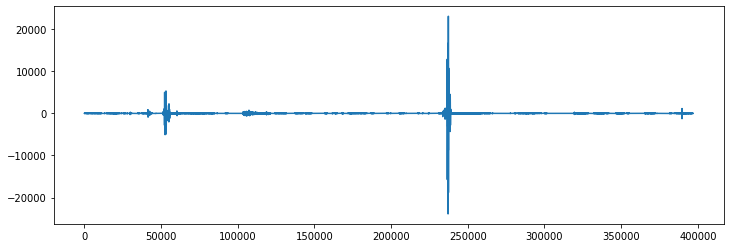

In [62]:
#plot the original audio
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)
plt.savefig('original_audio.png')
experiment.log_image('original_audio.png')

{'web': 'https://www.comet.ml/api/image/download?imageId=94a67def0e3745a1b1c2ef9673e12725&experimentKey=9d145cda85d7488c9408153fdf369848',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=94a67def0e3745a1b1c2ef9673e12725&experimentKey=9d145cda85d7488c9408153fdf369848',
 'imageId': '94a67def0e3745a1b1c2ef9673e12725'}

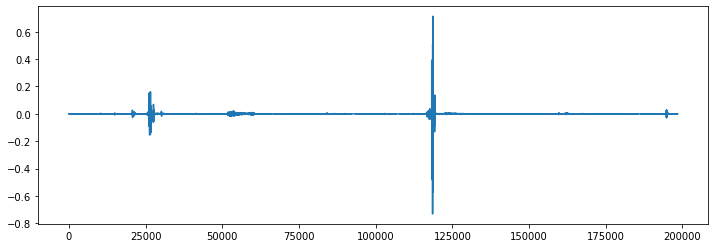

In [11]:
# plot the librosa audio mono sound
plt.figure(figsize=(12,4))
plt.plot(librosa_audio)
plt.savefig('librosa_audio.png')
experiment.log_image('librosa_audio.png')

## MFCCs - Mel-Frequency Cepstrum Coefficients

### Extract coefficients from only one file

In [12]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc = 40)
print(mfccs.shape)

(40, 388)


{'web': 'https://www.comet.ml/api/image/download?imageId=75d9d361b3fd490598b79ed17cce847b&experimentKey=9d145cda85d7488c9408153fdf369848',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=75d9d361b3fd490598b79ed17cce847b&experimentKey=9d145cda85d7488c9408153fdf369848',
 'imageId': '75d9d361b3fd490598b79ed17cce847b'}

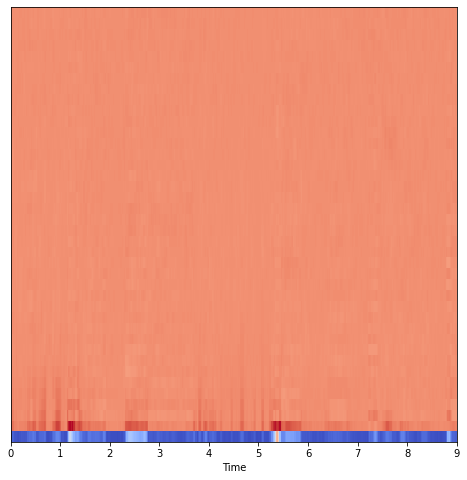

In [13]:
plt.figure(figsize=(8,8))
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')
plt.savefig('MFCCs.png')
experiment.log_image('MFCCs.png')

### Function to extract the MFCCs from every file in our dataset

In [14]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T,axis=0)
     
    return mfccs_processed

In [46]:
features = []# Iterate through each sound file and extract the features 

for index, row in df.iterrows():
    
    absolutePath = os.path.abspath("")
    fname = str(row["fname"])
    file_name = os.path.join(absolutePath,fname)
    
    class_label = row["label"]
    data = extract_features(file_name)

    
    features.append([data, class_label])
    
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

/home/chico/Desktop/taad/projeto/taad-project
set_a/artifact__201012172012.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/artifact__201105040918.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/artifact__201105041959.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/artifact__201105051017.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/artifact__201105060108.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/artifact__201105061143.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/artifact__201105190800.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/artifact__201105280851.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/artifact__201106010559.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/artifact__201106010602.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/artifact__201106021541.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/artifact__201106030612.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/

/home/chico/Desktop/taad/projeto/taad-project
set_a/normal__201103151912.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/normal__201103170121.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/normal__201103221214.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/normal__201104122156.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/normal__201104141251.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/normal__201105011626.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/normal__201105021654.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/normal__201105021804.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/normal__201105151450.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/normal__201106111136.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/normal__201106141148.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/normal__201106151236.wav
/home/chico/Desktop/taad/projeto/taad-project
set_a/normal__201106210943.wav

/home/chico/Desktop/taad/projeto/taad-project/env/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: [Errno 2] No such file or directory: '/home/chico/Desktop/taad/projeto/taad-project/set_a/__201012172010.wav'

In [ ]:
experiment.end()